# Gaussian Process on Network
## Learning subspaces for optimal latent representation

We have seen that Gaussian process can be used to predict the node attributes if we construct the process on the feature domain that is given by the spectral subspaces of graph Laplacian. 

Note that the spectral subspace is used to generate the latent representation, which in turn is used to optimize the Gaussian process. On the other hand, given the Gaussian process, we can change the subspace to optimize the overall performance.    

We first let the subspace move along the geodesic of the Grassmann manifold $\mathbb{G}(N,k)$. We will see how this change will make the clustering information change. An optimal subspace is then to choose that preserve the subspace information as much as possible. 

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.metrics.pairwise import rbf_kernel, pairwise_kernels
import GPy
import GPy.util as gutil

%matplotlib inline 

plt.close('all')
Ifsavefig =  False
Ifsavedata = False

/Applications/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Generate a bar-bell graph 

In [2]:
size = 40
color_map = {0:'r', 1:'c', 2:'y'}
#center = np.zeros(2)
#center[1] = 1
center = None

n = 40
m = 0
G0= nx.barbell_graph(n,m) 
#generate the bar-bell graph, which consists of two fully connected component and a path connecting them 

label0 = np.zeros([2*n,1])
label0[n:2*n] = np.ones([n,1])
# labeling of the cluster
for node in G0.nodes():
    G0.node[node]['category'] = int(label0[node,0])

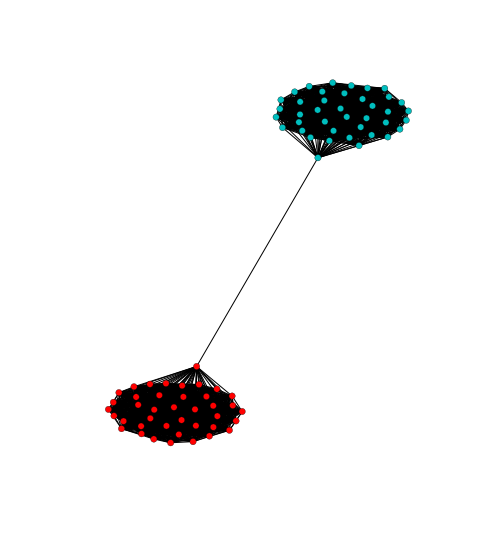

In [3]:
fig= plt.figure(1)
fig.set_size_inches(8.0, 8.0)


ax1 = plt.axes()
#ax = fig.add_axes([0, 0, 1.5, 1.5])

pos_spring = nx.spring_layout(G0)
ax=nx.draw(G0, pos=pos_spring, node_size = size,\
           node_color=[color_map[G0.node[node]['category']] for node in G0])  
limits=plt.axis('off') # turn of axis
txt = "A barbell graph (" + "n=" + str(n) + ", m=" + str(m) + ")" 
#plt.text(0.1,-0.1,txt, fontsize='x-large')
fig.subplots_adjust(wspace=0.3, top= 1)
if Ifsavefig:
    fig.savefig('../figures/graph_spring_plot_03_25_16.eps')

In [4]:
#generate the eigenspace of normalized Laplacian
k = 3
nnodes = nx.adjacency_matrix(G0).shape[0]

ncv=max(2*k+1,int(np.sqrt(nnodes)))

eigenvalues,eigenvectors= sp.sparse.linalg.eigsh(nx.laplacian_matrix(G0).asfptype(), k=k, \
                                                which='SM', return_eigenvectors = True, ncv=ncv)
index=np.argsort(eigenvalues)[1:k] # 0 index is zero eigenvalue    
pos_spectral_mat = np.real(eigenvectors[:,index]) #pos_spectral_mat is the spectral location of the nodes
pos_spectral_df = pd.DataFrame(data=pos_spectral_mat, columns=['PX','PY'], dtype=float)
pos_spectral_df['LABEL'] = label0


### Generate node attributes

In [5]:
T= 2
c = 2*np.pi*0.8
data_np = np.zeros([nnodes, T])
column_name = []
for t in np.arange(1,T+1):
    temp1 = np.multiply(pos_spectral_df['PX'].apply(lambda x: np.exp(-c*t*x)).values, \
                          pos_spectral_df['PY'].apply(lambda y: np.cos(c*t*y)).values)
    data_np[:,t-1] = temp1
    if t == 1:
        column_name = str(t-1)+"_cos"
    else:    
        column_name = [column_name, str(t-1)+"_cos"]

sigma = 0.1        
data_np = np.add(data_np, sigma*np.random.randn(nnodes, T))    
data_df = pd.DataFrame(data=data_np, columns=column_name, dtype=float)
data_df['LABEL'] = label0

X= data_np

### Kernel construction via GP-regression

In [6]:
U= pos_spectral_mat
latent_dim = U.shape[1]

In [7]:
print("Learn RBF kernel via optimization on log-likelihood")
rbf_kern = GPy.kern.RBF(2)
kernel = rbf_kern + GPy.kern.White(2)

model = GPy.models.GPRegression(X= U, Y = X, kernel = kernel)
model.Gaussian_noise.variance.constrain_bounded(1e-5, 0.1)
max_iters = 50
model.optimize(max_iters= max_iters, messages=True)

Learn RBF kernel via optimization on log-likelihood
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    00s03  07  -9.152497e+01   1.396100e+02 
    00s05  12  -9.218301e+01   4.277925e-01 
    00s06  15  -9.235180e+01   1.097694e+00 
    00s07  17  -9.235875e+01   6.187630e-04 
    00s09  20  -9.235876e+01   4.282144e-12 
Runtime:     00s09
Optimization status: Converged



In [8]:
print(model)


Name                              : GP regression
Log-likelihood                    : 92.3587602931
Number of Parameters              : 4
Number of Optimization Parameters : 4
Updates                           : True
Parameters:
  GP_regression.           |        Value        |  Constraint  |  Prior  |  Tied to
  sum.rbf.variance         |      2.46706105936  |     +ve      |         |         
  sum.rbf.lengthscale      |     0.181406544438  |     +ve      |         |         
  sum.white.variance       |  0.000128006070847  |     +ve      |         |         
  Gaussian_noise.variance  |   0.00820452689036  |  1e-05,0.1   |         |         


The RBF kernel $k(r)= l^2\exp\left(−\frac{1}{2\sigma^{2}}r^2\right) + \beta\,\delta$

In [9]:
variance = model['sum.rbf.variance'].values
lengthscale = model['sum.rbf.lengthscale'].values
Gaussian_noise = model['Gaussian_noise.variance'].values
Kernel = model.kern.K(U,U)

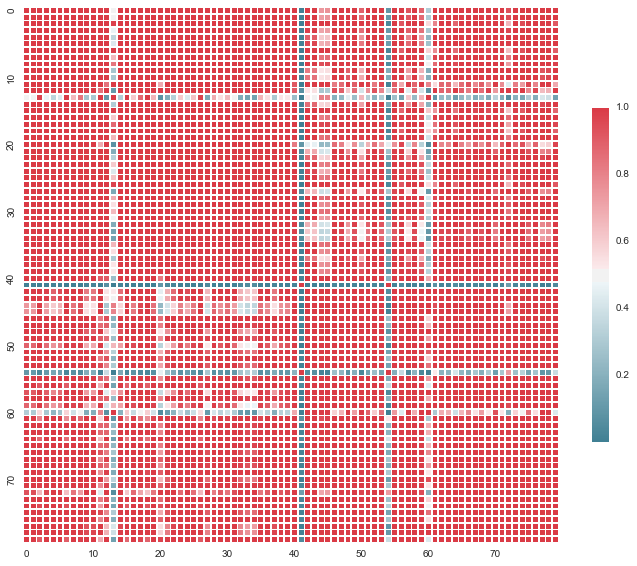

In [10]:
fig= plt.figure(1)
fig.set_size_inches(12.0, 12.0)
sns.set(style="white")

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = plt.axes()
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(Kernel, cmap=cmap, vmax=1, #.3,
            square=True, xticklabels=10, yticklabels=10,
            linewidths=.8, cbar_kws={"shrink": .5}, ax=ax)
#ax.set_title('sigmoid kernel', fontsize = 20)
plt.show()
if Ifsavefig:
    fig.savefig('../figures/rbf_kernel_03_25_16.eps')

### Compute the gradient $\frac{dL}{dU}$
The loss function is given as negative log-likelihood of Gaussian process

\begin{align}
\mathcal{L}(\beta, \sigma, \mathbf{U}) &= \frac{pN}{2}\log(2\pi)+\frac{p}{2}\log\det(\mathbf{K}_{\beta, \sigma, \mathbf{U}})+\frac{1}{2}\text{tr}\left(\mathbf{K}_{\beta, \sigma, \mathbf{U}}^{−1}\mathbf{X}\mathbf{X}^T\right)
\end{align}
The partial differential of $\mathcal{L}$ with respect to $\mathbf{K}$
\begin{align}
\mathbf{T}= \frac{dL}{dK} &= 2\mathbf{T}_{0} - \text{diag}\left(\mathbf{T}_{0}\right),\\
\mathbf{T}_{0} &= \frac{1}{2}\left(\mathbf{I} - \mathbf{K}_{\beta, \sigma, \mathbf{U}}^{-1}\mathbf{X}\mathbf{X}^T/p \right)\mathbf{K}_{\beta, \sigma, \mathbf{U}}^{-1}, \\
\mathbf{K}_{r,s} &= K_{\sigma}\left(\mathbf{U}_{r,:} , \mathbf{U}_{s,:}\right) + \beta \delta_{r,s}
\end{align}


In [11]:
S = gutil.linalg.tdot(X) 
KiX, _ = gutil.linalg.dpotrs(np.asfortranarray(Kernel), np.asfortranarray(S), lower=1)
# KiS = K^{-1}*X*X
KiXXiK, _ = gutil.linalg.dpotrs(np.asfortranarray(Kernel), np.asfortranarray(KiX.T), lower=1)
Ki,_ = gutil.linalg.dpotri(np.asfortranarray(Kernel), lower=1)
dL_dK_0 = 0.5*(T*Ki - KiXXiK)
dL_dK =  2*dL_dK_0 - np.diag(np.diag(dL_dK_0))

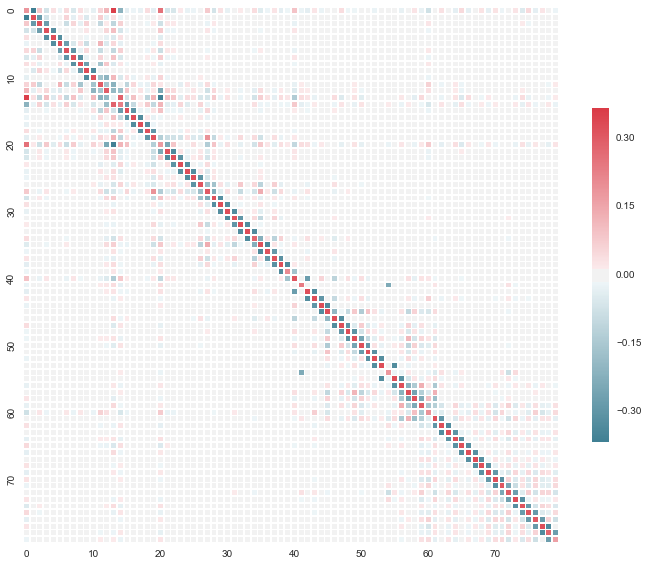

In [12]:
fig= plt.figure(2)
fig.set_size_inches(12.0, 12.0)
sns.set(style="white")

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = plt.axes()
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(dL_dK, cmap=cmap, vmax=np.max(np.max(dL_dK)), #.3,
            square=True, xticklabels=10, yticklabels=10,
            linewidths=.8, cbar_kws={"shrink": .5}, ax=ax)
#ax.set_title('sigmoid kernel', fontsize = 20)
plt.show()
if Ifsavefig:
    fig.savefig('../figures/dL_dK_03_25_16.eps')

For rbf kernel, 
\begin{align}
\frac{\partial \mathbf{K}_{\beta, \sigma, \mathbf{Z}}}{\partial \mathbf{U}_{m,j}} 
&= -\frac{l^{2}}{\sigma^2} \exp\left(-\frac{1}{2\sigma^2} \|\mathbf{U}_{m} -  \mathbf{U}_{n}\|^{2} \right)\left[2\left( \mathbf{U}_{m,i} - \mathbf{U}_{n,j} \right)\right]
\end{align}


In [13]:
U_scaled = U / lengthscale
Usquare = np.sum(np.square(U_scaled), 1)
K_dist2 = -2.*gutil.linalg.tdot(U_scaled) + (Usquare[:, None] + Usquare[None, :])
K_dvar = np.exp(-0.5 * K_dist2) # exp(-0.5*||zm - zn||^2 )

lengthscale2 = np.square(lengthscale)

K_dist = 2*(U[:, None, :] - U[None, :, :])
dK_dZ = (-variance / lengthscale2) * np.transpose(K_dvar[:, :, np.newaxis] * K_dist, (1, 0, 2))

The partial differential of $\mathcal{L}$ with respect to $\mathbf{U}$
\begin{align}
d_{U}\mathcal{L} &= \left[\text{tr}\left( \mathbf{T} \frac{\partial \mathbf{K}_{\beta, \sigma, \mathbf{U}}}{\partial \mathbf{U}_{m,j}} \right)\right]_{m,j},
\end{align}

In [14]:
dL_dU = np.sum(dK_dZ * dL_dK.T[:, :, None], 0)

### Compute the canonical gradient on Grassman manifold
The gradient direction is given by 
\begin{align}
\mathbf{G}_{0}= \nabla_{\mathbf{U}} \mathcal{L} &= (\mathbf{I} - \mathbf{U}_{0}\mathbf{U}_{0}^{T})d_{U}\mathcal{L}\\
\mathbf{H}_{0} &= - \mathbf{G}_{0}
\end{align}

In [15]:
U_orth = np.eye(nnodes) - np.dot(U, U.T)
H0 = -np.dot(U_orth, dL_dU)

In [16]:
U_sig, sig, Vh_sig =  sp.linalg.svd(H0, full_matrices=False)

### Compute the geodesic curve on Grassmann manifold along gradient direction
We need the formula for the geodesic on Grassmann manifold. Let $\mathbf{U}_{0} \in \mathbb{R}^{N \times k}$ be the initial point, an exponential map $\exp: \mathcal{T}_{\mathbf{U}_{0}}\mathbb{G} \rightarrow \mathbb{G}$ that projects a gradient vector $\mathbf{H}_{0}$ to a neighboring point on the geodesic curve is given by 

\begin{align}
\mathbf{U}_{t} &= \mathbf{U}_{0}\mathbf{V}_{0}\cos(\eta_{min}\boldsymbol{\Sigma}_0)\mathbf{V}^{T}_{0} + \mathbf{W}_{0}\sin(\eta_{min}\boldsymbol{\Sigma}_0)\mathbf{V}^{T}_{0},
\end{align}
where $\mathbf{H}_{0}= \mathbf{W}_{0}\boldsymbol{\Sigma}_{0}\mathbf{V}_{0}^{T}$


In [17]:
eta = 0.05

# sin(\eta \sigma) and cos(\eta \sigma)
Sig_cos = sp.linalg.diagsvd(np.cos(eta*sig), latent_dim, latent_dim)
Sig_sin = sp.linalg.diagsvd(np.sin(eta*sig), latent_dim, latent_dim)
# new subspace
U_new = gutil.linalg.mdot(U, (Vh_sig.T, Sig_cos, Vh_sig)) + gutil.linalg.mdot(U_sig, Sig_sin, Vh_sig)

In [18]:
np.dot(U_new.T, U_new) #check for orthogonality 

array([[  1.00000000e+00,   4.16333634e-17],
       [  4.16333634e-17,   1.00000000e+00]])

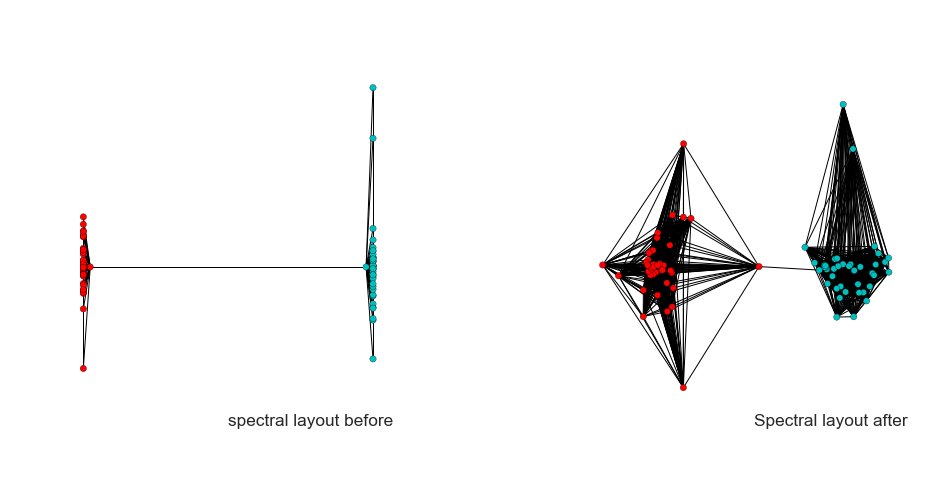

In [19]:
size = 40
color_map = {0:'r', 1:'c', 2:'y'}

fig= plt.figure(3)
fig.set_size_inches(16.0, 8.0)


ax2 = plt.subplot(121)
pos = U
#pos = nx.spring_layout(G1)
ax=nx.draw(G0,pos=pos, node_size = size,\
           node_color=[color_map[G0.node[node]['category']] for node in G0])  
limits=plt.axis('off') # turn of axis
txt = "spectral layout before" 
plt.text(0,-0.5,txt, fontsize='x-large')
fig.subplots_adjust(wspace=0.3)

plt.subplot(122)
pos1 = U_new #nx.spring_layout(G)
ax=nx.draw(G0,pos=pos1, node_size = size, \
           node_color=[color_map[G0.node[node]['category']] for node in G0])  
limits=plt.axis('off') # turn of axis
txt = "Spectral layout after"

plt.text(0,-0.5,txt, fontsize='x-large')
plt.subplots_adjust(hspace = .001)
if Ifsavefig:
    fig.savefig('../figures/spectral_layout_change_03_25_16.eps')

Make animation for different stepsize

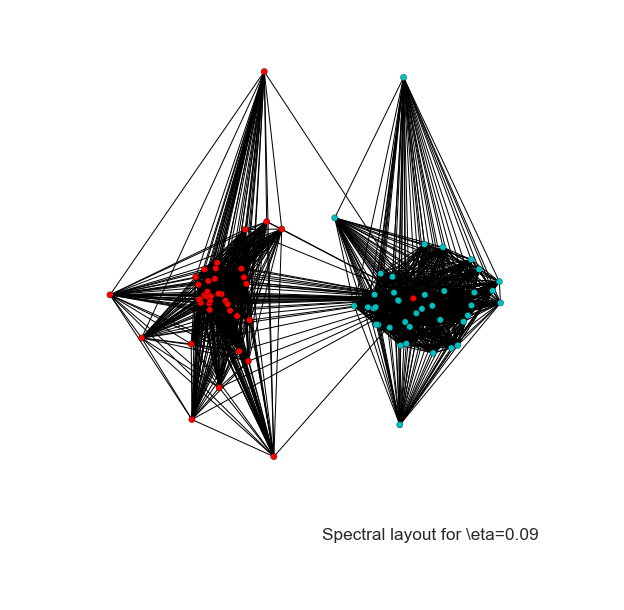

In [28]:
size = 40
color_map = {0:'r', 1:'c', 2:'y'}
Ifsavefig = True
eta = np.arange(10)*0.01

for i, eta_i in enumerate(eta):
    # sin(\eta \sigma) and cos(\eta \sigma)
    Sig_cos = sp.linalg.diagsvd(np.cos(eta_i*sig), latent_dim, latent_dim)
    Sig_sin = sp.linalg.diagsvd(np.sin(eta_i*sig), latent_dim, latent_dim)
    # new subspace
    U_new2 = gutil.linalg.mdot(U, (Vh_sig.T, Sig_cos, Vh_sig)) + gutil.linalg.mdot(U_sig, Sig_sin, Vh_sig)
    fig= plt.figure(4)
    fig.set_size_inches(8.0, 8.0)
    pos1 = U_new2 #nx.spring_layout(G)
    ax=nx.draw(G0,pos=pos1, node_size = size, \
           node_color=[color_map[G0.node[node]['category']] for node in G0])  
    limits=plt.axis('off') # turn of axis
    txt = "Spectral layout for \eta="+ str(eta_i)

    plt.text(0,-0.5,txt, fontsize='x-large')
    plt.subplots_adjust(hspace = .001)
    if Ifsavefig:
        filename = "../figures/spectral_layout_change_03_25_16_" + str(i) + ".eps"
        fig.savefig(filename)

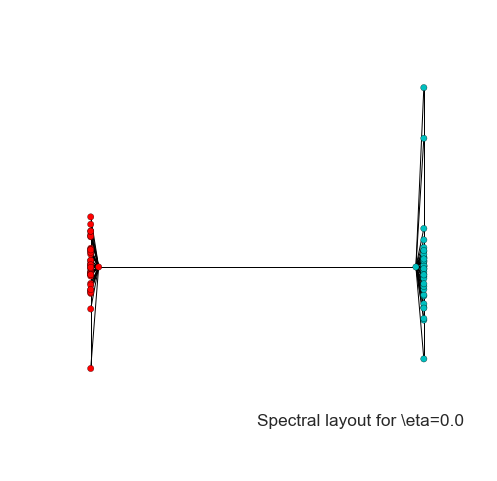

In [62]:
if Ifsavefig:
    from matplotlib import animation
    size = 40
    color_map = {0:'r', 1:'c', 2:'y'}
    center = [0,0]

    fig= plt.figure(5)
    fig.set_size_inches(8.0, 8.0)



    def animate(i):
        eta_i = 0.01*i
        fig.clf()
        axis = plt.axes()
        Sig_cos = sp.linalg.diagsvd(np.cos(eta_i*sig), latent_dim, latent_dim)
        Sig_sin = sp.linalg.diagsvd(np.sin(eta_i*sig), latent_dim, latent_dim)
        # new subspace
        U_new2 = gutil.linalg.mdot(U, (Vh_sig.T, Sig_cos, Vh_sig)) + gutil.linalg.mdot(U_sig, Sig_sin, Vh_sig)
        pos1 = U_new2 #nx.spring_layout(G)
        ax=nx.draw(G0,pos=pos1, node_size = size, \
                   node_color=[color_map[G0.node[node]['category']] for node in G0])  
        limits=plt.axis('off') # turn of axis
        txt = "Spectral layout for \eta="+ str(eta_i)

        plt.text(0,-0.5,txt, fontsize='x-large') 
        return axis

    # Animator call
    anim = animation.FuncAnimation(fig, animate, frames=40, interval=500)
    anim.save("../figures/animation_03_28_16.mp4")

import random
 #### Graph initialization
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4, 5, 6, 7, 8, 9])
G.add_edges_from([(1,2), (3,4), (2,5), (4,5), (6,7), (8,9), (4,7), (1,7), (3,5), (2,7), (5,8), (2,9), (5,7)])

#### Animation funciton
def animate2(i):
    colors = ['r', 'b', 'g', 'y', 'w', 'm']
    nx.draw_circular(G, node_color=[random.choice(colors) for j in range(9)])

nx.draw_circular(G)
fig = plt.gcf()

#### Animator call
anim2 = animation.FuncAnimation(fig, animate2, frames=20, interval=20)
anim2.save("../figures/animation_03_28_16.mp4")                